# Gromore basic domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [52]:
#import packages
import flopy
import numpy as np
import matplotlib as mp
import os
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv
from numpy import asarray
from numpy import savetxt

#print full output
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

#Delete Packages
# dir = "/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/GroMore_Project/amanda/scenario5"
# #dir = "C:\Users\vivek\Documents\UA Coursework\HWRS 582 Groundwater Modelling\GroMore_Project\Vivek\Scenario 1"
# #dir = "/Users/hardknox47/Desktop/HWRS482/hw482/GroMore_Project/Justin"

# files = os.listdir(dir)
# ext=['.dis','.bas','.lpf','.oc','.pcg','.wel','.hds','.cbc','.riv','.list','.nam','.evt',
#      '.rch','.mpbas','.mpend','.mplst','.mpnam','.mppth','.mpsim','.log','.timeseries',
#      '.lis','.chd','.ddn','.sloc']
# for file in files:
#     for i in range(0,len(ext)):
#         if file.endswith(ext[i]):
#             os.remove(os.path.join(dir,file))

# Scenario 5: Post agriculture model with seasonality - future projection
Add the proposed agricultural element (pumping and localized recharge) for growing pistachios to your post-development model with seasonality. Agriculture starts now, 100 years after the end of the burn-in. Both pumping and recharge related to agriculture occur at the rates described and are continuous throughout the year.

## 2. Discretization and other inputs

In [53]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Subsurface properties
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 49.0)
ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), 
        int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 

rip_ET= 5e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
rip_rows_forced = (21.0, 28.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)
rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), 
        int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 

extinction_depth = 10 #m

## Recharge
rech=4e-5  #m/d
rechag=0.00015#*0.125  # (0.0001, 0.00015, 0.0002) m/day (wheat, pistachios, cotton)

rechxy=[(0,0),(0,36000)]  #recharge zone

#rechag_rows=(28,29)
#rechag_cols=(18,19)

rechag_rows=(27,29)
rechag_cols=(17,19)

rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 15.0)

rech_zone = np.zeros((1,nrow,ncol))
rech_zone[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),
          int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
rech_zone[0,int(rechag_rows[0]):int(rechag_rows[1]),
          int(rechag_cols[0]):int(rechag_cols[1])]=rechag
#print("recharge location forced(col, row)", rech_cols_forced,rech_rows_forced)

# Setting up wells
#pumping1 = 0 # m3/day      -1500 pumping rate for water supply well  
pumping2 = -4500#*0.125 # m^3/d   (-3000,-4500,-6000) irrigation well pumping rate (wheat, pistachios, cotton)

#well_agua = [2,29,37, pumping1] #Well loc (layer, row, column)
well_ag = [0,38,12, pumping2] #Well loc (layer, row, column)
MW1 = [0,25,24,0]
MW2 = [0,37,12,0]

#wel_spd = {0: [well_agua, well_ag, MW1, MW2]}

## init boundary conditions
#h_right = 70

In [54]:
# savetxt('rech_zone.csv', rech_zone[0], delimiter=',')

### Layering

In [55]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 

## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 

## Boundary Conditions

In [56]:
#setup initial heads as the end of scenario 2 burn in values (after 200 years w. seasonality)

H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[0, :, :] = np.genfromtxt('top_head_postdevel_100yr.csv', delimiter=',', dtype=float)  #initialize the top layer with 200 yr burn in vals
H_init[1, :, :] = np.genfromtxt('mid_head_postdevel_100yr.csv', delimiter=',', dtype=float)  #initialize the mid layer with 200 yr burn in vals
H_init[2, :, :] = np.genfromtxt('bot_head_postdevel_100yr.csv', delimiter=',', dtype=float)  #initialize the bottom layer with 200 yr burn in vals

#Adding no flow boundaries
#########################

# Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  # 1st col = no flow       
ibound[:,:,49] = -1  # last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

## River Properties

In [57]:
#DEFINE RIVERS
riv_row= 24
riv_sp = [] #create list to store all river cells for stress period 1
k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(1)*(1000)/(sed_thick) #river bed conductance in m^2/d
r_stage = .5 #stage in river (stress period 1)
r_bott = ztop[riv_row,:] #river bottom
#print(r_bott)
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
#create dictionary of stress period data
riv_spd = {0: riv_sp}

### Setting up seasonality


In [58]:
#We start in October, because that's a water year
sp_peryr = 2        # periods for seasonality (two stress periods per year)
sp1_len = 180       # Length of stress period 1 in days, October-March, no ET
sp2_len = 180      # Length of stress period 2 in days. April - September, regular ET
sim_years = 100       #number of years for transient simulation 
#nper = int(sp_peryr*sim_years + 1) # 201
nper = int(sp_peryr*sim_years)

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False # transient flag is false
#steady[0] = True    # initial stress period is steady-state or true

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)#100 repeating sets of the two stress periods
#perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen/30  
#nstp[0]=1 #for the steady state solution we just want one output

### Setting up seasonal ET

In [59]:
#Setup alternating ET values
#ET_zone has the seasonal ET values
                      
ET_dict = {} #set up an ET dictionary, where each key is a stress period num 0-50
ET_zone2 = ET_zone * 0 
for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
    if p == 0:
        ET_dict[p] = ET_zone2
    elif int(p % 2) != 0:
        ET_dict[p]=ET_zone
        #print(p)
    else: 
        ET_dict[p] = ET_zone2

## Setting up the post development pumping

In [60]:
#addings these pumping wells for aguaseca community well
t=np.arange(0,210,10)
# print(t)
pumping_spd={}
for a in range(0,len(t)):
    pumping_spd[a]=[2,29,37,-(1.5*(t[a])**(1.5))]
# print(pumping_spd)

#Set up the wel data for stress periods, changing well_agua pumping rate
wel_spd = {}  

i=11

for p in range(0,201): #nper = 201
    if (199>p>0 and ((p) % 20) == 0):
        i=i+1
    if (p >= 0 and p <= 21):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 41):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 61):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p<= 81):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 101):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 121):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 141):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 161):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 181):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 201):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    else:
        print('p not in range')

## Set up and run scenario 3

In [61]:
#Initialize the model
modelname = "Scenario_5"
moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"
# moddir="/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp = nstp)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)

#create rch object
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     


# Attach ET package
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_dict, exdp=extinction_depth, ipakcb=53) 

wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

#Setting up RIV package
riv = flopy.modflow.ModflowRiv(model=m,stress_period_data = riv_spd, ipakcb=53)

#Output control - OC 
oc_spd = {}
for kper in range(1,nper): #nper is 201, this is the key for each entry in oc_spd dict
    oc_spd[(kper, 1)] = ['save head','save drawdown','save budget','print head','print budget']
    oc_spd[(kper, 90)] = ['save head','save drawdown','save budget','print head','print budget']
    oc_spd[(kper, 150)] = ['save head','save drawdown','save budget','print head','print budget']
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

#Numerical solver - pcg
# pcg = flopy.modflow.ModflowPcg(model=m)
#Numerical solver - pcg
#pcg = flopy.modflow.ModflowPcg(model=m, mxiter=1000, iter1=100, relax = 0.95, damp = 0.5)
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=5000, iter1=100, relax = 0.95, damp = 0.1)

#write the inputs
m.write_input()   

# m.evt.check()
# m.oc.check()
# m.oc.check()
# m.lpf.check()
# m.pcg.check()
# m.riv.check()
# m.rch.check()
# m.dis.check()

In [62]:
#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Scenario_5.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/28 13:34:54

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress 

 Solving:  Stress period:    17    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     5    Ground-Wa

 Solving:  Stress period:    35    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:     3    Ground-Wa

 Solving:  Stress period:    53    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     1    Ground-Wa

 Solving:  Stress period:    70    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:     5    Ground-Wa

 Solving:  Stress period:    88    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:     3    Ground-Wa

 Solving:  Stress period:   106    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     1    Ground-Wa

 Solving:  Stress period:   123    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     5    Ground-Wa

 Solving:  Stress period:   141    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:     3    Ground-Wa

 Solving:  Stress period:   159    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     1    Ground-Wa

 Solving:  Stress period:   176    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     5    Ground-Wa

 Solving:  Stress period:   194    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     3    Ground-Wa

## Checking domain

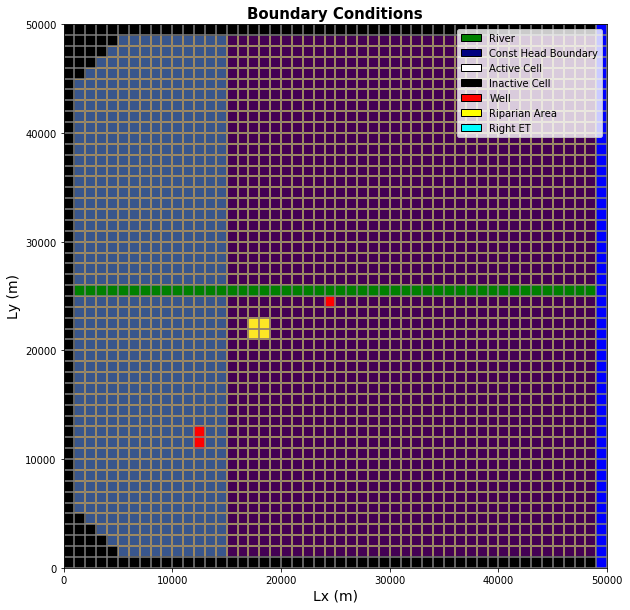

In [63]:
#CHECK BOUNDARY CONDITIONS
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#zones = ET_zone + rech_zone
#quadmesh = modelmap.plot_array(zones)
recharge = modelmap.plot_array((rech_zone), color = 'orange')
#ET = modelmap.plot_array(ET_zone)
riv_plot = modelmap.plot_bc(ftype='RIV')
wel_plot = modelmap.plot_bc(ftype='WEL')
quadmesh = modelmap.plot_ibound()

#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Boundary Conditions', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'),
                   mp.patches.Patch(color='navy',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   mp.patches.Patch(color='Red',label='Well',ec='black'),
                   mp.patches.Patch(color='Yellow',label='Riparian Area',ec='black'),
                   mp.patches.Patch(color='cyan',label='Right ET',ec='black')],)

## Read in the outputs

In [64]:
modelname = "Scenario_5"
hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times()                               # returns a list of timesteps

#extract binary data from head file
head = {} #create dictionary to store head data 
frf = {} #create dictionary to store flows through right cell face 
fff = {} #create dictionary to store flows through front cell face 
storage = {} #create dictionary to store storage
ET = {}

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

#get data from python objects
for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data() #append heads to head list for ea stress per
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) 
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
    #storage['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)
    #ET['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)


## Plot head at monitoring wells

In [65]:
#get time series for a certain cell

cell_id1 = (0,25,24) #cell ID of MW1
cell_id2 = (0,37,12) #cell ID of MW2
ag_id = (0,38,12)#cell ID of ag well
agua_id = (2,29,37) #Cell ID of aguaseca community well

time_series1 = headobj.get_ts(cell_id1) #get the time series at MW1
time_series2 = headobj.get_ts(cell_id2) #get the time series at MW2
time_series_ag = headobj.get_ts(ag_id) #get the time series at ag well
time_series_agua = headobj.get_ts(agua_id) #get the time series at agua seca com well
#print(time_series_ag)
time_series={'MW1': [time_series1],'MW2': [time_series2],
             'ag_well': [time_series_ag],'agua_well': [time_series_agua]}
print(time_series.keys())
print(time_series['MW1'][0])

dict_keys(['MW1', 'MW2', 'ag_well', 'agua_well'])
[[  240.          78.626366]
 [  420.          78.87947 ]
 [  600.          78.62799 ]
 [  780.          78.88126 ]
 [  960.          78.62865 ]
 [ 1140.          78.88169 ]
 [ 1320.          78.62869 ]
 [ 1500.          78.88143 ]
 [ 1680.          78.62818 ]
 [ 1860.          78.88068 ]
 [ 2040.          78.62735 ]
 [ 2220.          78.87935 ]
 [ 2400.          78.62624 ]
 [ 2580.          78.87778 ]
 [ 2760.          78.624954]
 [ 2940.          78.87634 ]
 [ 3120.          78.623535]
 [ 3300.          78.87481 ]
 [ 3480.          78.62203 ]
 [ 3660.          78.87276 ]
 [ 3840.          78.61985 ]
 [ 4020.          78.87091 ]
 [ 4200.          78.61805 ]
 [ 4380.          78.86911 ]
 [ 4560.          78.61625 ]
 [ 4740.          78.86732 ]
 [ 4920.          78.61448 ]
 [ 5100.          78.86555 ]
 [ 5280.          78.612724]
 [ 5460.          78.8638  ]
 [ 5640.          78.61101 ]
 [ 5820.          78.862076]
 [ 6000.          78.6

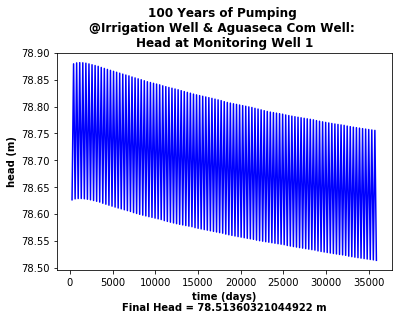

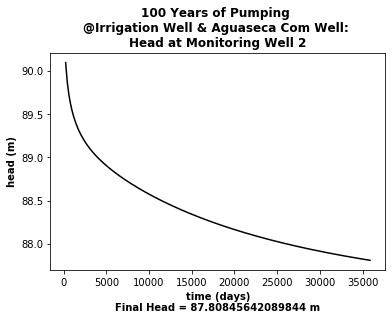

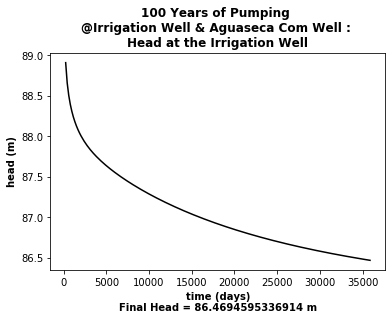

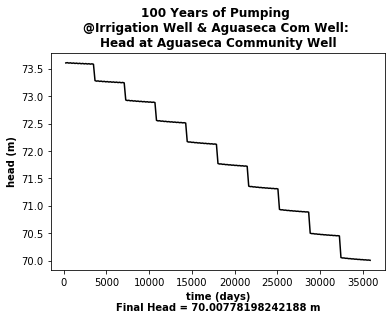

In [66]:

#create plot of MW1
plt.subplot(1, 1, 1)
ax=plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title("100 Years of Pumping \n@Irrigation Well & Aguaseca Com Well: \nHead at Monitoring Well 1"
          ,fontweight='bold')
plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][0, 25, 24]} m",fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record
plt.savefig("Head_M1_S5.png",dpi=600,bbox_inches='tight')
plt.show()

#create plot of MW2
plt.subplot(1, 1, 1)
ax=plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title("100 Years of Pumping \n@Irrigation Well & Aguaseca Com Well: \nHead at Monitoring Well 2"
          ,fontweight='bold')
plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][0, 37, 12]} m",fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series2[:, 0], time_series2[:, 1], 'k-') #plot the time series with points at each record
plt.savefig("Head_M2_S5.png",dpi=600,bbox_inches='tight')
plt.show()

#create plot of Ag well
plt.subplot(1, 1, 1)
ax=plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title("100 Years of Pumping \n@Irrigation Well & Aguaseca Com Well : \nHead at the Irrigation Well"
          ,fontweight='bold')
plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][0,38,12]} m",fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series_ag[:, 0], time_series_ag[:, 1], 'k-') #plot the time series with points at each record
plt.savefig("Head_Aq_S5.png",dpi=600,bbox_inches='tight')
plt.show()

#create plot of Aguaseca com well
plt.subplot(1, 1, 1)
ax=plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title("100 Years of Pumping \n@Irrigation Well & Aguaseca Com Well: \nHead at Aguaseca Community Well"
          ,fontweight='bold')
plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][2, 29, 37]} m",fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series_agua[:, 0], time_series_agua[:, 1], 'k-') #plot the time series with points at each record
plt.savefig("Head_Aqua_S5.png",dpi=600,bbox_inches='tight')
plt.show()

## ET 

In [67]:
ET_data = budgobj.get_data(text='ET')
#print(np.sum(ET_data[0]))
ET_time_series = []
x_val = []
for x in (range(len(ET_data))):
    #print("The ET sum at ",x,'is',np.sum(ET_data[x]))
    test_sum = np.sum(ET_data[x])
    if test_sum == 2500:
        print("skipped")
    else:
        ET_time_series.append(test_sum)
        x_val.append(x)
        print("attached")
        
#output 0-3 (beginning), ET is applied
#output 594-596 (the end), I'm applying ET
#Output 591-595, no ET
#Why am I getting positive ET value where it should be zero? Is this the recharge?

attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipped
attached
skipp

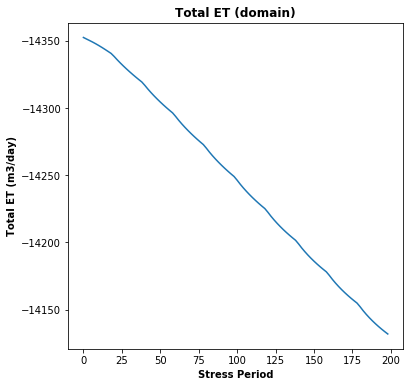

In [68]:
#print(len(ET_time_series))
#print(len(x_val))
#print(x_val)

fig = plt.figure(figsize=(6, 6))
plt.plot(x_val, ET_time_series)
plt.gca().invert_yaxis()
plt.plot()
plt.title('Total ET (domain)',fontweight='bold')
plt.xlabel('Stress Period', fontweight = 'bold')
plt.ylabel("Total ET (m3/day)", fontweight = 'bold')
                    
plt.show()

## Recharge

In [69]:
# Recharge_data = budgobj.get_data(text='RECHARGE')
# for x in (range(len(Recharge_data))):
#     print("The recharge sum at ",x,'is',np.sum(Recharge_data[x]))

## River Leakage

In [70]:
leakage = budgobj.get_data(text='RIVER LEAKAGE')
#print(len(leakage))
#print(head.keys())
#print(head['sp0'][0])
#print(len(leakage))
#print(np.shape(leakage))
#print(leakage)

posit_ET_pos = len(leakage)-1
no_ET_pos = len(leakage)-4
#print(posit_ET_pos)

leak=leakage[posit_ET_pos]#time step with positive ET
tot_leak = sum(leak.q)

leak2=leakage[no_ET_pos] #time step with zero ET
tot_leak2 = sum(leak2.q)

print("Total Daily flux from river to groundwater (Oct-March SP, no ET)", tot_leak2, "m3/day")
print("Total Daily flux from river to groundwater (Apr-Sept SP, pos ET)", tot_leak, "m3/day")

Total Daily flux from river to groundwater (Oct-March SP, no ET) 7881.206830978394 m3/day
Total Daily flux from river to groundwater (Apr-Sept SP, pos ET) 12448.51573753357 m3/day


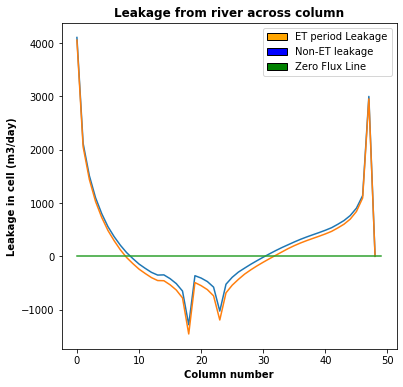

In [71]:
x2 = []
for n in range(0,50):
    x2.append(n)
y2 = np.zeros(50)
fig = plt.figure(figsize=(6, 6))
x = list(range(49))
plt.plot(x, leak.q)
plt.plot(x, leak2.q)
plt.plot(x2, y2)
plt.plot()
plt.title('Leakage from river across column',fontweight='bold')
plt.xlabel('Column number', fontweight = 'bold')
plt.ylabel("Leakage in cell (m3/day)", fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='orange',label='ET period Leakage',ec='black'),
                   mp.patches.Patch(color='blue',label='Non-ET leakage',ec='black'),
                    mp.patches.Patch(color='green',label='Zero Flux Line',ec='black')])
                    
plt.show()

## Water Budget

In [72]:
#print(len(storage))
#print(type(storage))
#print(np.sum(storage[0]))
storage = budgobj.get_data(text='STORAGE')
storage_series = []

x_val_stor = []
for x in (range(len(storage))):
    #print("The storage sum at ",x,'is',np.sum(storage[x]))
    test_sum = np.sum(storage[x])
    storage_series.append(test_sum)
    x_val_stor.append(x)

#     if test_sum == 2500:
#         print("skipped")
#     else:
#         ET_time_series.append(test_sum)
#         x_val.append(x)
#         print("attached")


In [73]:
print(sum(storage_series))

519722.138671875


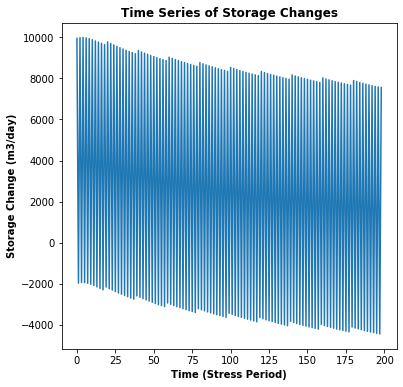

In [74]:
fig = plt.figure(figsize=(6, 6))
plt.plot(x_val_stor, storage_series)
plt.plot()
plt.title('Time Series of Storage Changes',fontweight='bold')
plt.xlabel('Time (Stress Period)', fontweight = 'bold')
plt.ylabel("Storage Change (m3/day)", fontweight = 'bold')

                    
plt.show()

## Saving final head array to start init heads in scen4

In [75]:
head_top = head['sp%s'%(len(head)-1)][0,:,:]
head_mid = head['sp%s'%(len(head)-1)][1,:,:]
head_bot = head['sp%s'%(len(head)-1)][2,:,:]

savetxt('top_head_postdevel_200yr_w_ag.csv', head_top, delimiter=',')
savetxt('mid_head_postdevel_200yr_w_ag.csv', head_mid, delimiter=',')
savetxt('bot_head_postdevel_200yr_w_ag.csv', head_bot, delimiter=',')

In [76]:
#Getting final heads
print("Final Head at Monitoring Well 1 = ", head['sp%s'%(len(head)-1)][0, 25, 24],'m')
print("Final Head at Monitoring Well 2 = ", head['sp%s'%(len(head)-1)][0, 37, 12],'m')
print("Final Head at Irrigation Well  = ", head['sp%s'%(len(head)-1)][0, 38, 12],'m')
print("Final Head at Aguaseca Community Well = ", head['sp%s'%(len(head)-1)][2, 29, 37],'m')

Final Head at Monitoring Well 1 =  78.5136 m
Final Head at Monitoring Well 2 =  87.80846 m
Final Head at Irrigation Well  =  86.46946 m
Final Head at Aguaseca Community Well =  70.00778 m


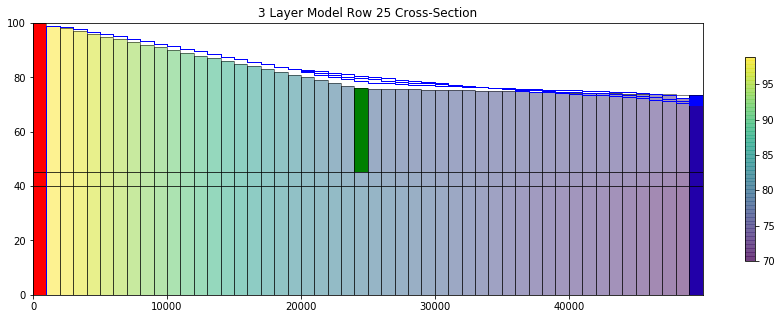

In [77]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 25}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
headpc = head['sp%s'%(len(head)-1)]
pc = xsect.plot_array(headpc,masked_values=[-999.99], head=headpc, alpha=0.5)
patches = xsect.plot_bc('WEL', color='green')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)

# Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head[0,:,:]
wt = xsect.plot_surface(head['sp%s'%(len(head)-1)], color='blue', lw=1)

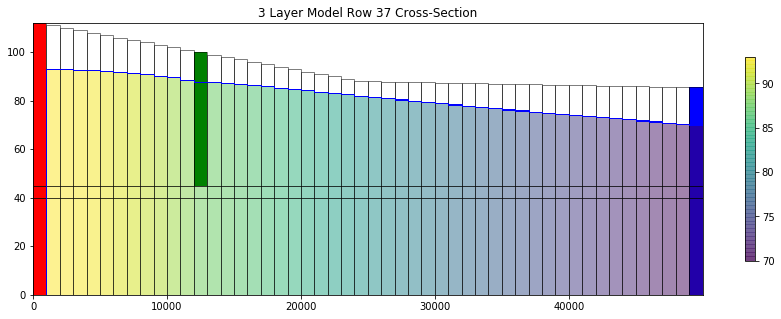

In [78]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 37}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
headpc = head['sp%s'%(len(head)-1)]
pc = xsect.plot_array(headpc,masked_values=[-999.99], head=headpc, alpha=0.5)
patches = xsect.plot_bc('WEL', color='green')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 37 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)

# Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head[0,:,:]
wt = xsect.plot_surface(head['sp%s'%(len(head)-1)], color='blue', lw=1)

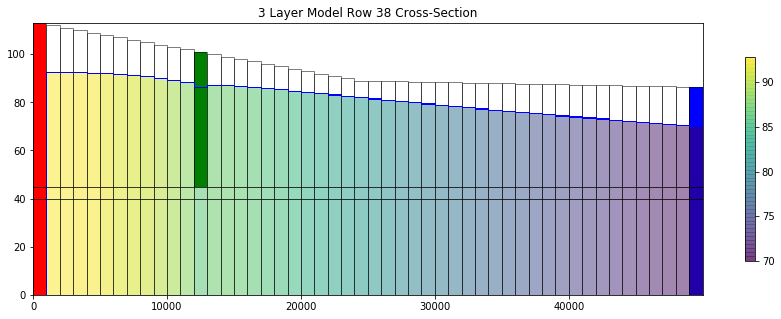

In [79]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 38}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
headpc = head['sp%s'%(len(head)-1)]
pc = xsect.plot_array(headpc,masked_values=[-999.99], head=headpc, alpha=0.5)
patches = xsect.plot_bc('WEL', color='green')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 38 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)

# Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head[0,:,:]
wt = xsect.plot_surface(head['sp%s'%(len(head)-1)], color='blue', lw=1)

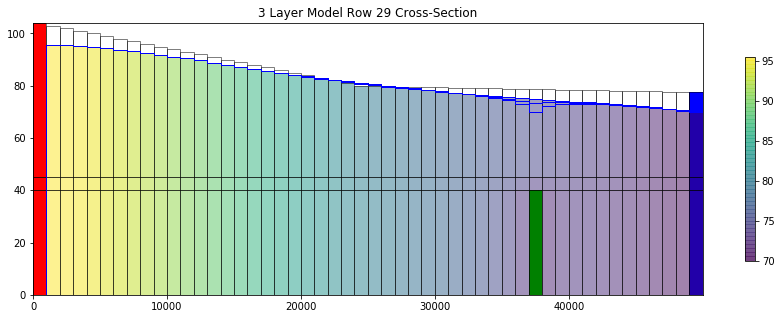

In [80]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 29}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
headpc = head['sp%s'%(len(head)-1)]
pc = xsect.plot_array(headpc,masked_values=[-999.99], head=headpc, alpha=0.5)
patches = xsect.plot_bc('WEL', color='green')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 29 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)

# Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head[0,:,:]
wt = xsect.plot_surface(head['sp%s'%(len(head)-1)], color='blue', lw=1)

In [81]:
import pickle

# with open('head_postdevel_200yr_w_ag.pickle', 'wb') as f:
#     pickle.dump(head, f)

# with open('storage_postdevel_200yr_w_ag.pickle', 'wb') as f:
#     pickle.dump(storage, f)

# with open('leakage_postdevel_200yr_w_ag.pickle', 'wb') as f:
#     pickle.dump(leakage, f)

# with open('ET_data_postdevel_200yr_w_ag.pickle', 'wb') as f:
#     pickle.dump(ET_data, f)

# with open('frf_postdevel_200yr_w_ag.pickle', 'wb') as f:
#     pickle.dump(frf, f)

# with open('fff_postdevel_200yr_w_ag.pickle', 'wb') as f:
#     pickle.dump(fff, f)

with open('time_series_postdevel_200yr_w_ag.pickle', 'wb') as f:
    pickle.dump(time_series, f)



In [82]:
# moddirmp="C:\WRDAPP\modpath_7_2_001\mpath7"
moddirmp="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mp7"

mpname=os.path.join(modelname + '_mp')

locsb = [[0,27,17, 0,29,19]]

# set the number of particles per cell
sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=2, rowcelldivisions=2, layercelldivisions=1)

# setup theparticles
p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb])
pg2 = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
particlegroups = [pg2]

defaultiface = {'RECHARGE': 6, 'ET': 6}

#setup  the modpath packages
mp = flopy.modpath.Modpath7(modelname=modelname + '_mp', flowmodel=m, exe_name=moddirmp)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=n, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='stop_at',
                                  weaksourceoption='stop_at',
                                  budgetoutputoption='summary',
                                  stoptimeoption='extend', 
                                  particlegroups= particlegroups)

mp.add_package(rch)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

mp.get_package_list()

FloPy is using the following  executable to run the model: /Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mp7

MODPATH Version 7.2.001   
Program compiled Apr 22 2020 09:57:57 with GFORTRAN compiler (ver. 8.2.0)       


Program received signal SIGSEGV: Segmentation fault - invalid memory reference.

Backtrace for this error:
#0  0x10a1589ac
#1  0x10a157d53
#2  0x7fff722a85fc
#3  0x10a120bed
#4  0x10a12578a
#5  0x10a129ba8


['MPBAS', 'MPSIM', 'RCH']